# Calculate inter-subject Euclidean distance matrix for SPSQ-SF questionnaire scores

In [3]:
import os
import glob
from pathlib import Path

import numpy as np
from scipy.stats import rankdata, ttest_rel, ttest_1samp, zscore
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import pandas as pd
import seaborn as sns

import nibabel as nib

from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from sklearn.manifold import TSNE

%matplotlib inline

In [4]:
data_dir = '/project/3013104.01'
os.chdir(data_dir)

## Check distributions

In [13]:
questionnaire_data = pd.read_csv(os.path.join(data_dir, 'analysis/SPSQ-24_all.csv'), header=0, index_col=0)
questionnaire_data.head()

,as_SPS13_emotionally_touched_music_art,as_SPS29_notice_subtle_touching_tones_music,as_SPS31_very_movedy_nice_work_of_art,SPSQ_as,ep_SPS02_nervous_to_many_things_at_once,ep_SPS24_rushed_too_much_little_time,ep_SPS28_upset_when_people_ask_many_things_at_once,SPSQ_ep,sa_SPS03_see_sad_eyes_behind_smile,sa_SPS04_strikes_tone_voice_not_matching_words,...,sd_SPS25_suffer_bright_light,SPSQ_sd,ss_SPS14_immediately_feel_mouth_throat_drier,ss_SPS15_hardly_visible_details_attract_attention,ss_SPS21_quickly_aware_changes_body,ss_SPS23_notice_faints_smells,SPSQ_ss,SPSQ_sum,SPSQ_pos,SPSQ_neg
subject,,,,,,,,,,,,,,,,,,,,,
subject-0001,1,1,1,3,1,1,4,6,1,4,...,1,7,7,6,4,7,24,79,66,13
subject-0003,6,6,6,18,1,3,4,8,1,6,...,4,20,4,6,6,6,22,125,97,28
subject-0004,4,4,4,12,4,4,4,12,4,5,...,3,13,4,3,4,4,15,103,78,25
subject-0005,3,5,2,10,3,6,4,13,6,6,...,5,21,6,6,5,3,20,123,89,34
subject-0006,6,5,4,15,5,4,4,13,6,6,...,5,19,6,4,5,4,19,126,94,32


### Plot distributions for each dimension

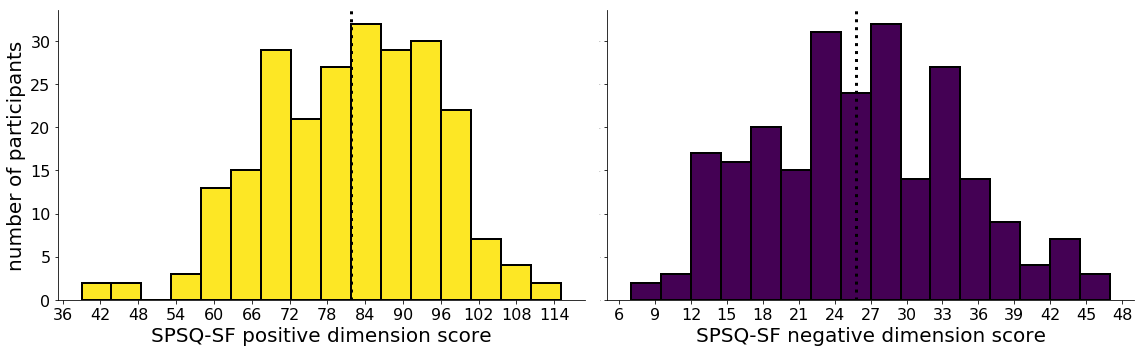

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Separate DataFrames for each variable
SPSQ_pos_data = questionnaire_data['SPSQ_pos']
SPSQ_neg_data = questionnaire_data['SPSQ_neg']

# Figure size in inches (length, width)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))  # Create two subplots side by side

# Plot the histograms for Positive SPSQ dimension
n_bins = 16
ax1.hist(SPSQ_pos_data, color='#fde725', bins=n_bins, alpha=1, label='Positive', edgecolor='#000000', linewidth=2)
pos_mean = SPSQ_pos_data.mean()
ax1.axvline(pos_mean, color='black', linestyle='dotted', linewidth=3)
ax1.set_xlabel('SPSQ-SF positive dimension score', fontsize=20)
ax1.set_ylabel('number of participants', fontsize=20)
ax1.tick_params(axis='both', labelsize=16)
ax1.xaxis.set_major_locator(plt.MaxNLocator(15))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot the histograms for Negative SPSQ dimension
ax2.hist(SPSQ_neg_data, color='#440154', bins=n_bins, alpha=1, label='Negative', edgecolor='#000000', linewidth=2)
neg_mean = SPSQ_neg_data.mean()
ax2.axvline(neg_mean, color='black', linestyle='dotted', linewidth=3)
ax2.set_xlabel('SPSQ-SF negative dimension score', fontsize=20)
ax2.tick_params(axis='y', labelsize=0)  # Remove y-axis tick labels
ax2.tick_params(axis='x', labelsize=16)
ax2.set_ylabel('')  # Remove y-axis title
ax2.xaxis.set_major_locator(plt.MaxNLocator(15))
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plot as a PDF
plt.savefig('analysis/plots/histograms_spsq_scores_split.pdf')

plt.show()


## Calculate Cronbach's alpha

### Pre-define columns

In [16]:
sum_score = ['as_SPS13_emotionally_touched_music_art', 'as_SPS29_notice_subtle_touching_tones_music',
                       'as_SPS31_very_movedy_nice_work_of_art', 'ep_SPS02_nervous_to_many_things_at_once',
                       'ep_SPS24_rushed_too_much_little_time', 'ep_SPS28_upset_when_people_ask_many_things_at_once',
                       'sa_SPS03_see_sad_eyes_behind_smile', 'sa_SPS04_strikes_tone_voice_not_matching_words',
                       'sa_SPS09_looking_eyes_telling_truth', 'sa_SPS12_strikes_when_acting_not_afraid',
                       'sa_SPS22_tell_smile_masking_feelings', 'sc_SPS05_hard_enjoy_little_things_reversed',
                       'sc_SPS10_feel_good_with_people_I_love', 'sc_SPS17_enjoy_humour_situations',
                       'sc_SPS19_enjoy_relaxing_activity', 'sc_SPS30_watching_nice_movie_feels_good',
                       'sd_SPS06_flashing_lights_bother', 'sd_SPS16_easily_disturbed_light_odors',
                       'sd_SPS20_loud_noises_irritating', 'sd_SPS25_suffer_bright_light',
                       'ss_SPS14_immediately_feel_mouth_throat_drier',
                       'ss_SPS15_hardly_visible_details_attract_attention',
                       'ss_SPS21_quickly_aware_changes_body', 'ss_SPS23_notice_faints_smells'] # 24 items

positive_score = ['as_SPS13_emotionally_touched_music_art', 'as_SPS29_notice_subtle_touching_tones_music',
                       'as_SPS31_very_movedy_nice_work_of_art',
                       'sa_SPS03_see_sad_eyes_behind_smile', 'sa_SPS04_strikes_tone_voice_not_matching_words',
                       'sa_SPS09_looking_eyes_telling_truth', 'sa_SPS12_strikes_when_acting_not_afraid',
                       'sa_SPS22_tell_smile_masking_feelings', 'sc_SPS05_hard_enjoy_little_things_reversed',
                       'sc_SPS10_feel_good_with_people_I_love', 'sc_SPS17_enjoy_humour_situations',
                       'sc_SPS19_enjoy_relaxing_activity', 'sc_SPS30_watching_nice_movie_feels_good',
                       'ss_SPS14_immediately_feel_mouth_throat_drier',
                       'ss_SPS15_hardly_visible_details_attract_attention',
                       'ss_SPS21_quickly_aware_changes_body', 'ss_SPS23_notice_faints_smells'] # 17 items

negative_score = ['ep_SPS02_nervous_to_many_things_at_once',
                       'ep_SPS24_rushed_too_much_little_time', 'ep_SPS28_upset_when_people_ask_many_things_at_once',
                       'sd_SPS06_flashing_lights_bother', 'sd_SPS16_easily_disturbed_light_odors',
                       'sd_SPS20_loud_noises_irritating', 'sd_SPS25_suffer_bright_light'] # 7 items

### Calculate alpha

In [24]:
import numpy as np
import pandas as pd
import os

def cronbach_alpha(items):
    # Compute the covariance matrix
    cov_mat = np.cov(items, rowvar=False)
    
    # Compute the pseudo-inverse of the covariance matrix
    cov_inv = np.linalg.pinv(cov_mat)
    
    # Number of items
    num_items = items.shape[1]
    
    # Calculate Cronbach's alpha
    alpha = (num_items / (num_items - 1)) * (1 - np.trace(cov_mat @ cov_inv) / np.sum(np.diag(cov_mat)))
    
    return alpha

questionnaire_data = pd.read_csv(os.path.join(os.getcwd(), 'analysis/SPSQ-24_all.csv'), header=0, index_col=0)

# Check Data Loading
#print(questionnaire_data.head())

# Check Data Types
#print(questionnaire_data.dtypes)

# Check Missing Values
#print(questionnaire_data.isnull().sum())

# Check Variable Names
#print(questionnaire_data.columns)

# Convert positive and negative scores to arrays
positive_array = positive_score.values
negative_array = negative_score.values

# Calculate Cronbach's alpha
alpha_positive = cronbach_alpha(positive_array)
alpha_negative = cronbach_alpha(negative_array)

print("Positive dimension Cronbach's alpha:", alpha_positive)
print("Negative dimension Cronbach's alpha:", alpha_negative)

Positive dimension Cronbach's alpha: 0.520127974684
Negative dimension Cronbach's alpha: 0.753000987208


#### Heatmap

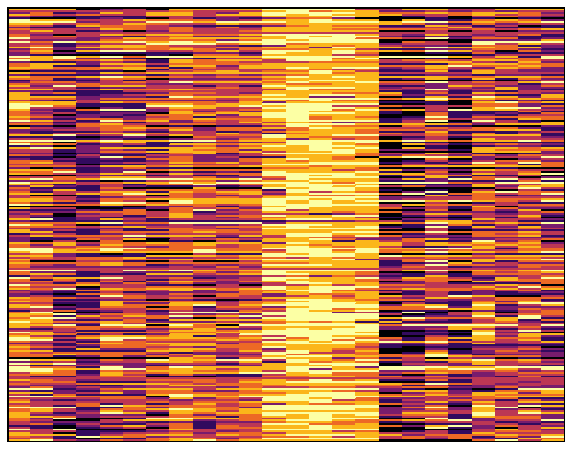

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('SPSQ-24_all.csv', header=0, index_col=0)
# Define a list of column names to exclude from the heatmap
columns_to_exclude = ['SPSQ_as', 'SPSQ_ep', 'SPSQ_sa', 'SPSQ_sc', 'SPSQ_sd', 'SPSQ_ss', 'SPSQ_sum','SPSQ_pos','SPSQ_neg'] 
data = data.drop(columns=columns_to_exclude, errors='ignore')
plt.figure(figsize=(10, 8))  # Set the figure size
ax = sns.heatmap(data, cmap="inferno", cbar=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('')
ax.hlines([0, data.shape[0]], 0, data.shape[1], colors='black', linewidth=3)
ax.vlines([0, data.shape[1]], 0, data.shape[0], colors='black', linewidth=3)
plt.show()

## Calculate questionnaire response similarity

### Euclidean distance (i.e., nearest neighbor)

#### Specify which questionnaire items to use

In [11]:
sum_score = ['as_SPS13_emotionally_touched_music_art', 'as_SPS29_notice_subtle_touching_tones_music',
                       'as_SPS31_very_movedy_nice_work_of_art', 'ep_SPS02_nervous_to_many_things_at_once',
                       'ep_SPS24_rushed_too_much_little_time', 'ep_SPS28_upset_when_people_ask_many_things_at_once',
                       'sa_SPS03_see_sad_eyes_behind_smile', 'sa_SPS04_strikes_tone_voice_not_matching_words',
                       'sa_SPS09_looking_eyes_telling_truth', 'sa_SPS12_strikes_when_acting_not_afraid',
                       'sa_SPS22_tell_smile_masking_feelings', 'sc_SPS05_hard_enjoy_little_things_reversed',
                       'sc_SPS10_feel_good_with_people_I_love', 'sc_SPS17_enjoy_humour_situations',
                       'sc_SPS19_enjoy_relaxing_activity', 'sc_SPS30_watching_nice_movie_feels_good',
                       'sd_SPS06_flashing_lights_bother', 'sd_SPS16_easily_disturbed_light_odors',
                       'sd_SPS20_loud_noises_irritating', 'sd_SPS25_suffer_bright_light',
                       'ss_SPS14_immediately_feel_mouth_throat_drier',
                       'ss_SPS15_hardly_visible_details_attract_attention',
                       'ss_SPS21_quickly_aware_changes_body', 'ss_SPS23_notice_faints_smells'] # 24 items

positive_score = ['as_SPS13_emotionally_touched_music_art', 'as_SPS29_notice_subtle_touching_tones_music',
                       'as_SPS31_very_movedy_nice_work_of_art',
                       'sa_SPS03_see_sad_eyes_behind_smile', 'sa_SPS04_strikes_tone_voice_not_matching_words',
                       'sa_SPS09_looking_eyes_telling_truth', 'sa_SPS12_strikes_when_acting_not_afraid',
                       'sa_SPS22_tell_smile_masking_feelings', 'sc_SPS05_hard_enjoy_little_things_reversed',
                       'sc_SPS10_feel_good_with_people_I_love', 'sc_SPS17_enjoy_humour_situations',
                       'sc_SPS19_enjoy_relaxing_activity', 'sc_SPS30_watching_nice_movie_feels_good',
                       'ss_SPS14_immediately_feel_mouth_throat_drier',
                       'ss_SPS15_hardly_visible_details_attract_attention',
                       'ss_SPS21_quickly_aware_changes_body', 'ss_SPS23_notice_faints_smells'] # 17 items

negative_score = ['ep_SPS02_nervous_to_many_things_at_once',
                       'ep_SPS24_rushed_too_much_little_time', 'ep_SPS28_upset_when_people_ask_many_things_at_once',
                       'sd_SPS06_flashing_lights_bother', 'sd_SPS16_easily_disturbed_light_odors',
                       'sd_SPS20_loud_noises_irritating', 'sd_SPS25_suffer_bright_light'] # 7 items

### Heatmap of items per dimension

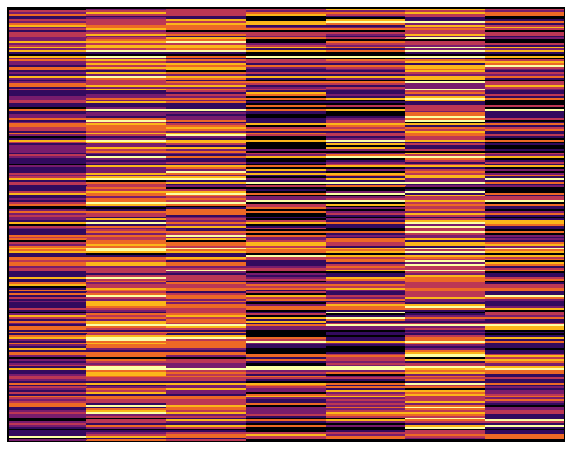

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('SPSQ-24_all.csv', header=0, index_col=0)
columns_to_include = negative_score 
data = data[columns_to_include]
plt.figure(figsize=(10, 8))  # Set the figure size
ax = sns.heatmap(data, cmap="inferno", cbar=False)
ax.set_xticks([])
ax.set_yticks([])
ax.hlines([0, data.shape[0]], 0, data.shape[1], colors='black', linewidth=3)
ax.vlines([0, data.shape[1]], 0, data.shape[0], colors='black', linewidth=3)
ax.set_ylabel('')
plt.show()

In [5]:
# To use composite scores instead of vector of scores:
sum_score = 'SPSQ_sum'
positive_score = 'SPSQ_pos'
negative_score = 'SPSQ_neg'

In [10]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
import os

# List of dimension composite scores
dimensions = ['SPSQ_sum', 'SPSQ_pos', 'SPSQ_neg']

# Read the SPSQ score file once
data = pd.read_csv(os.path.join(data_dir, 'SPSQ-24_all.csv'), header=0, index_col=0)

# Create an empty dictionary to store distance matrices for each dimension
distance_matrices = {}

for dim in dimensions:
    # Select the column for the current dimension
    scores_column = data[dim]

    # Initialize an empty DataFrame for the distance matrix
    distance_matrix = pd.DataFrame(index=scores_column.index, columns=scores_column.index)

    # Calculate pairwise Euclidean distances
    for i in scores_column.index:
        for j in scores_column.index:
            distance = euclidean([scores_column.loc[i]], [scores_column.loc[j]])
            distance_matrix.loc[i, j] = distance

    # Store the distance matrix in the dictionary
    distance_matrices[dim] = distance_matrix

    # Export Euclidean distance matrix to csv
    distance_matrix.to_csv(f'similarity_matrices_spsq/SPSQ-24_all/euclidean_distance_matrix_{dim}.csv', index=True)

# Now, distance_matrices contains the inter-subject distance matrices for each dimension


We chose to use questionnaire distance matrices in our IS-RSA (as opposed to similarity or dissimilarity) because (1) distance is a form of dissimilarity (i.e., greater distance is greater dissimilarity) and (2) converting distance to a similarity measure would change the relationships of the data points with one another. Rank-based transformation is a non-linear transformation.

### Plot heatmap arranged by SPSQ-SF score

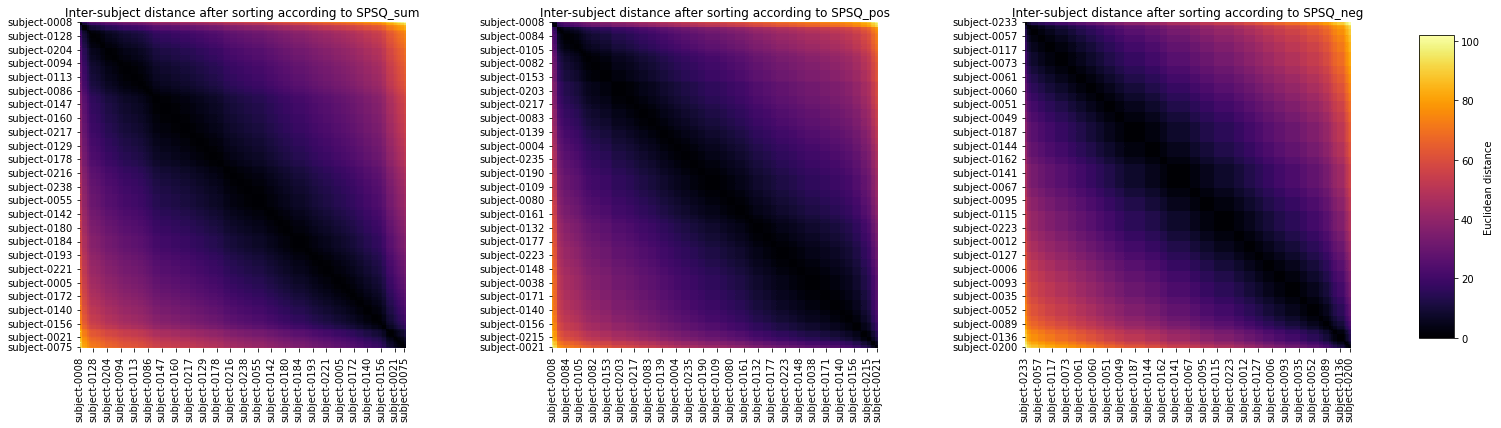

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to create a sorted heatmap
def sort_heatmap(file_path, sorting_file, variable, ax, title):
    # Read the distance matrix
    distance_matrix_df = pd.read_csv(file_path, header=0, index_col=0)

    # Read the sorting file
    sorting_df = pd.read_csv(sorting_file)

    # Sort the subjects based on the specified variable in ascending order
    sorted_order = sorting_df.sort_values(by=variable, ascending=True)['subject'].tolist()

    # Reorder both the rows and columns of the distance matrix using the sorted order
    distance_matrix_df = distance_matrix_df.loc[sorted_order, sorted_order]

    # Create the heatmap with sorting
    sns.heatmap(distance_matrix_df, ax=ax, annot=False, cmap='inferno', cbar=False, square=True, linewidths=0,
                vmin=distance_matrix_df.values.min(), vmax=distance_matrix_df.values.max())

    # Set tick labels for subjects along both x and y-axes every 10 subjects, including the last tick
    num_subjects = len(sorted_order)
    step = 10  # Display every 10th label
    tick_positions = list(range(0, num_subjects, step))
    tick_positions.append(num_subjects - 1)  # Add the last tick position

    # Use list comprehension to select tick labels based on the sorted order
    x_tick_labels = [sorted_order[i] for i in tick_positions]
    y_tick_labels = [sorted_order[i] for i in tick_positions]

    ax.set_xticks(tick_positions)
    ax.set_xticklabels(x_tick_labels, rotation=90)  # Rotate x-axis labels for better readability
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(y_tick_labels, rotation=0)  # Rotate y-axis labels for better readability

    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Define the file paths and sorting file for the variables you want to use
file_paths = {
    'SPSQ_sum': 'similarity_matrices_spsq/SPSQ-24_all/euclidean_distance_matrix_SPSQ_sum.csv',
    'SPSQ_pos': 'similarity_matrices_spsq/SPSQ-24_all/euclidean_distance_matrix_SPSQ_pos.csv',
    'SPSQ_neg': 'similarity_matrices_spsq/SPSQ-24_all/euclidean_distance_matrix_SPSQ_neg.csv'
}

sorting_file = 'SPSQ-24_all.csv'

# Create subplots for each variable and create the sorted heatmap
fig, axes = plt.subplots(1, len(file_paths), figsize=(24, 6))  # Adjust the figure size

# Initialize vmin and vmax for color normalization
vmin = float('inf')
vmax = float('-inf')

for i, (variable, file_path) in enumerate(file_paths.items()):
    ax = axes[i]
    title = f'Inter-subject distance after sorting according to {variable}'
    
    # Define distance_matrix_df within the loop
    distance_matrix_df = pd.read_csv(file_path, header=0, index_col=0)
    
    sort_heatmap(file_path, sorting_file, variable, ax, title)
    
    # Update vmin and vmax to encompass the values of all heatmaps
    vmin = min(vmin, distance_matrix_df.values.min())
    vmax = max(vmax, distance_matrix_df.values.max())

# Create a single color bar for all heatmaps using the common normalization range
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the colorbar position
sm = plt.cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  # An empty array is required for the scalar mappable
plt.colorbar(sm, cax=cax, label="Euclidean distance")

# Show the plot
plt.show()

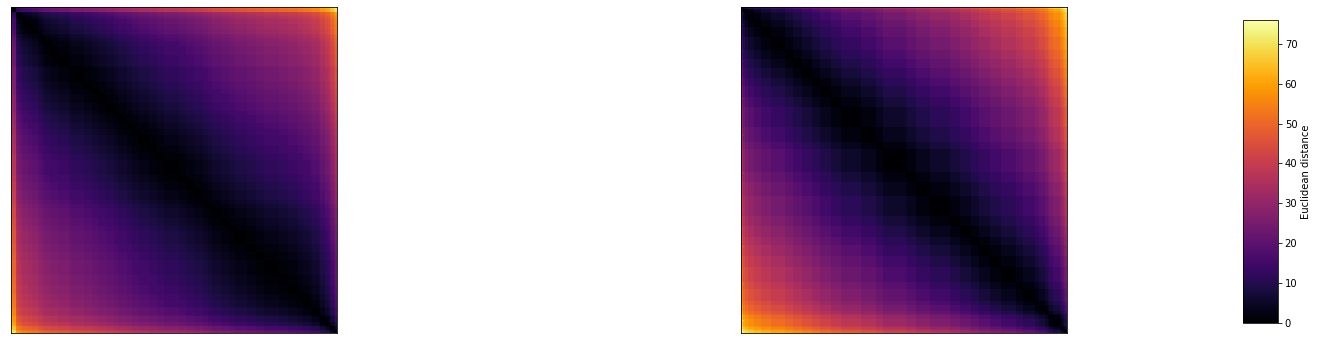

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to create a sorted heatmap
def sort_heatmap(file_path, sorting_file, variable, ax, title):
    # Read the distance matrix
    distance_matrix_df = pd.read_csv(file_path, header=0, index_col=0)

    # Read the sorting file
    sorting_df = pd.read_csv(sorting_file)

    # Sort the subjects based on the specified variable in ascending order
    sorted_order = sorting_df.sort_values(by=variable, ascending=True)['subject'].tolist()

    # Reorder both the rows and columns of the distance matrix using the sorted order
    distance_matrix_df = distance_matrix_df.loc[sorted_order, sorted_order]

    # Create the heatmap with sorting
    sns.heatmap(distance_matrix_df, ax=ax, annot=False, cmap='inferno', cbar=False, square=True, linewidths=0,
                vmin=distance_matrix_df.values.min(), vmax=distance_matrix_df.values.max())

    # Remove tick labels and tick marks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('')  # Remove the title
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Add a black line around the plot
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')

# Define the file paths and sorting file for the variables you want to use
file_paths = {
    'SPSQ_pos': 'inter-subject_matrices_spsq/euclidean_distance_composite/euclidean_distance_matrix_SPSQ_pos.csv',
    'SPSQ_neg': 'inter-subject_matrices_spsq/euclidean_distance_composite/euclidean_distance_matrix_SPSQ_neg.csv'
}

sorting_file = 'SPSQ-24_all.csv'

# Create subplots for each variable and create the sorted heatmap
fig, axes = plt.subplots(1, len(file_paths), figsize=(24, 6))  # Adjust the figure size

# Initialize vmin and vmax for color normalization
vmin = float('inf')
vmax = float('-inf')

for i, (variable, file_path) in enumerate(file_paths.items()):
    ax = axes[i]
    title = f'Inter-subject distance after sorting according to {variable}'
    
    # Define distance_matrix_df within the loop
    distance_matrix_df = pd.read_csv(file_path, header=0, index_col=0)
    
    sort_heatmap(file_path, sorting_file, variable, ax, title)
    
    # Update vmin and vmax to encompass the values of all heatmaps
    vmin = min(vmin, distance_matrix_df.values.min())
    vmax = max(vmax, distance_matrix_df.values.max())

# Create a single color bar for all heatmaps using the common normalization range
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the colorbar position
sm = plt.cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  # An empty array is required for the scalar mappable
plt.colorbar(sm, cax=cax, label="Euclidean distance")

# Show the plot
plt.show()
